# CS-7641 Assignment 4

In [7]:
import gymnasium as gym
import time
import pygame
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

from algorithms.rl import RL
# from examples.test_env import TestEnv
from algorithms.planner import Planner
from examples.plots import Plots

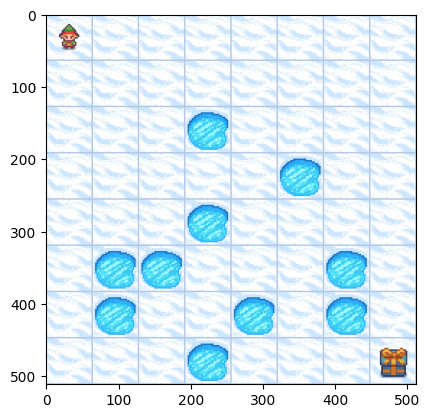

In [3]:
frozen_lake = gym.make('FrozenLake8x8-v1', render_mode='rgb_array')
frozen_lake.reset()

frozen_lake.render()
plt.imshow(frozen_lake.render())
plt.show()
# # Q-learning
# Q, V, pi, Q_track, pi_track = RL(frozen_lake.env).q_learning()

# test_scores = TestEnv.test_env(env=frozen_lake.env, render=True, user_input=False, pi=pi)

## Value Iteration

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


runtime = 0.03 seconds


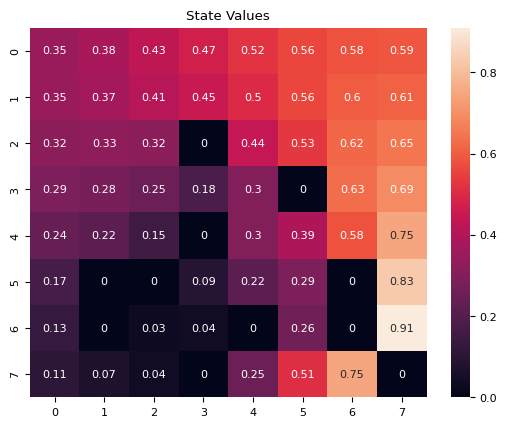

runtime = 0.15 seconds


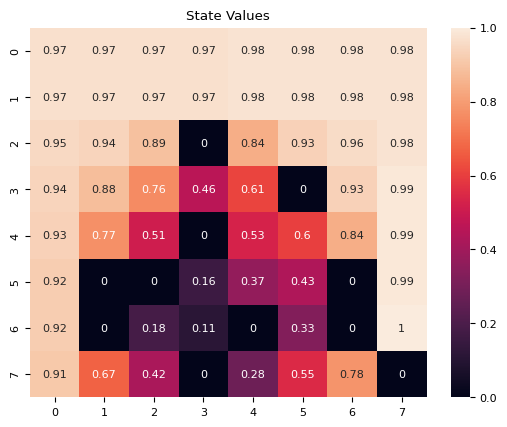

runtime = 0.24 seconds


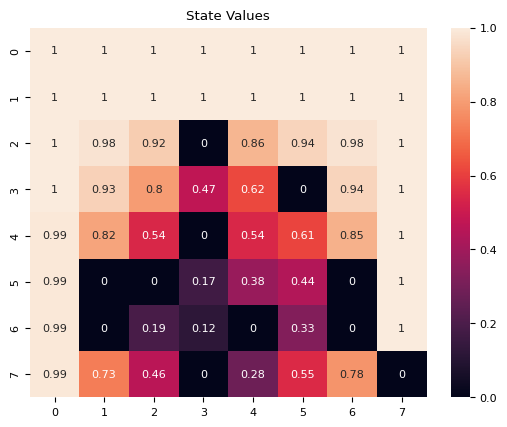

runtime = 0.36 seconds


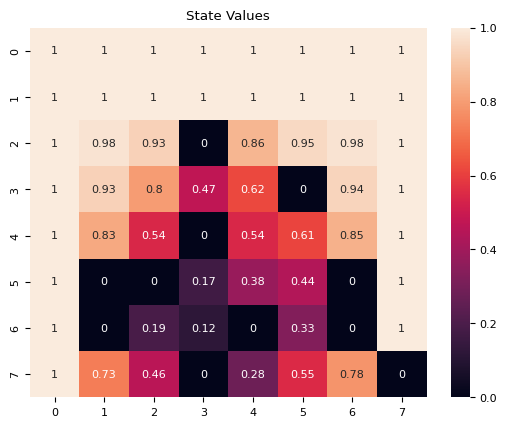

In [102]:
def generate_transition_and_reward_arrays(env):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    # Initialize arrays for transition probabilities and rewards
    transition_probs = np.zeros((num_states, num_actions, num_states))
    rewards = np.zeros((num_states, num_actions, num_states))

    # Extract transition probabilities and rewards from the environment
    for s in range(num_states):
        for a in range(num_actions):
            transitions = env.P[s][a]
            for transition in transitions:
                prob, next_state, reward, _ = transition
                transition_probs[s, a, next_state] = prob
                rewards[s, a, next_state] = reward

    return transition_probs, rewards

# Generate transition probabilities and rewards
fl_T, fl_R = generate_transition_and_reward_arrays(frozen_lake)

epsilon_values = [1e-2, 1e-3, 1e-4, 1e-5]

planner = Planner(frozen_lake.P)

V_list = []
V_track_list = []
pi_list = []
time_list = []
scores_list = []

# for i in gamma_iter:
for e in epsilon_values:
    start_time = time.time()
    V, V_track, pi = planner.value_iteration(gamma=1.0, n_iters=1000, theta=e)

    V_list.append(V)
    V_track_list.append(V_track)
    pi_list.append(pi)
    time_list.append(time.time() - start_time)
    Plots.grid_values_heat_map(V, "State Values")

    test_scores = TestEnv.test_env(env=frozen_lake.env, render=False, user_input=False, pi=pi)
    scores_list.append(test_scores)
    


c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


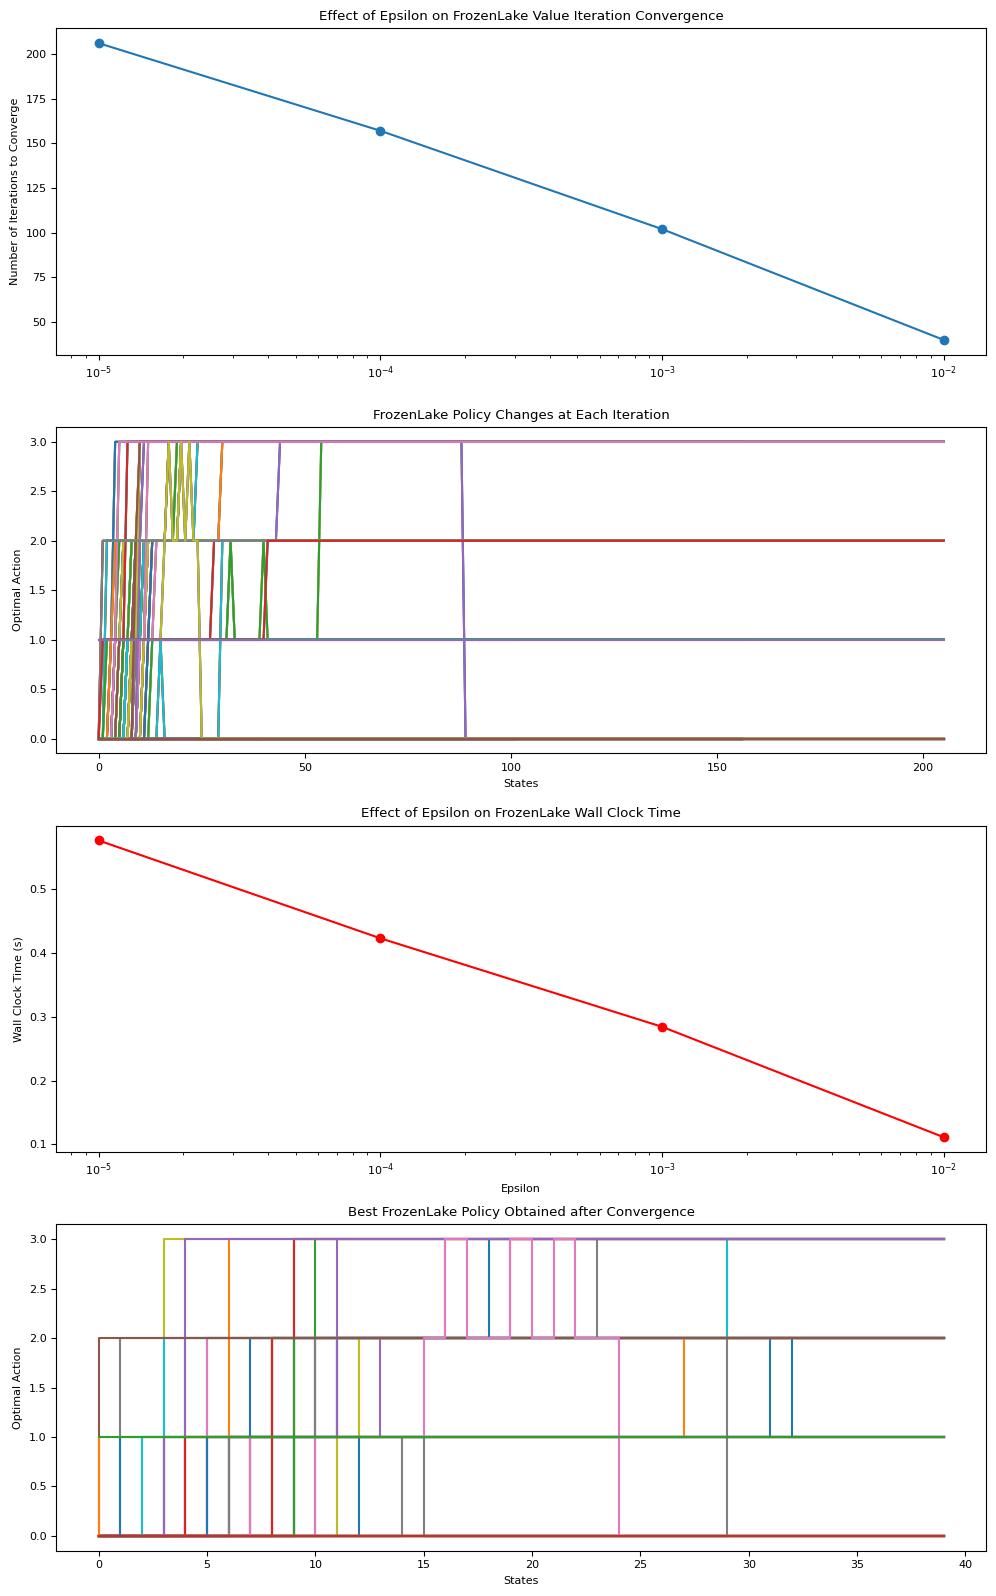

In [103]:
def value_iteration(env, epsilon):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Initialize value function and policy
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    
    # Discount factor
    gamma = 0.99

    # Lists to store policies at each iteration and elapsed time
    policy_iterations = []
    elapsed_times = []

    # Perform Value Iteration
    start_time = time.time()
    iterations = 0
    while True:
        delta = 0
        for s in range(num_states):
            v = V[s]
            
            # Update the value function using the Bellman equation
            bellman_update = [sum([p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(num_actions)]
            V[s] = max(bellman_update)
            
            # Update policy
            policy[s] = np.argmax(bellman_update)
            
            delta = max(delta, np.abs(v - V[s]))

        # Store the policy at each iteration
        policy_iterations.append(policy.copy())

        iterations += 1
        # Check for convergence
        if delta < epsilon:
            end_time = time.time()
            elapsed_times.append(end_time - start_time)
            break

    return policy_iterations, iterations, elapsed_times

def plot_epsilon_vs_iterations_and_policies_and_time(epsilon_values, num_iterations_values, policy_iterations, elapsed_times, problem_name):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16), sharex=False)

    ax1.plot(epsilon_values, num_iterations_values, marker='o')
    ax1.set_xscale('log')  # Use logarithmic scale for better visualization
    ax1.set_ylabel('Number of Iterations to Converge')
    ax1.set_title(f'Effect of Epsilon on {problem_name} Value Iteration Convergence')

    # Plot policies at each iteration
    for i, policies in enumerate(policy_iterations):
        ax2.plot(range(len(policies)), policies, label=f"Iteration {i + 1}")

    ax2.set_xlabel('States')
    ax2.set_ylabel('Optimal Action')
    ax2.set_title(f'{problem_name} Policy Changes at Each Iteration')
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot wall clock time
    ax3.plot(epsilon_values, elapsed_times, marker='o', color='r')
    ax3.set_xscale('log')  # Use logarithmic scale for better visualization
    ax3.set_xlabel('Epsilon')
    ax3.set_ylabel('Wall Clock Time (s)')
    ax3.set_title(f'Effect of Epsilon on {problem_name} Wall Clock Time')

    # Plot the best policy
    best_policy = get_best_policy(policy_iterations, num_iterations_values)
    ax4.step(range(len(best_policy)), best_policy)
    ax4.set_xlabel('States')
    ax4.set_ylabel('Optimal Action')
    ax4.set_title(f'Best {problem_name} Policy Obtained after Convergence')

    plt.tight_layout()
    plt.show()

def get_best_policy(policy_iterations, num_iterations):
    # Find the policy with the minimum number of iterations (i.e., the best policy)
    best_policy_index = np.argmin(num_iterations)
    best_policy = policy_iterations[best_policy_index]
    return best_policy


# Vary epsilon values
num_iterations_values_frozenlake = []
policy_iterations_list_frozenlake = []
elapsed_times_list_frozenlake = []

for epsilon in epsilon_values:
    policy_iterations, num_iterations, elapsed_times = value_iteration(frozen_lake, epsilon)
    num_iterations_values_frozenlake.append(num_iterations)
    policy_iterations_list_frozenlake.append(policy_iterations)
    elapsed_times_list_frozenlake.append(elapsed_times)

# Plot results for FrozenLake
plot_epsilon_vs_iterations_and_policies_and_time(epsilon_values, num_iterations_values_frozenlake, policy_iterations_list_frozenlake, elapsed_times_list_frozenlake, 'FrozenLake')



## Policy Iteration

runtime = 0.01 seconds


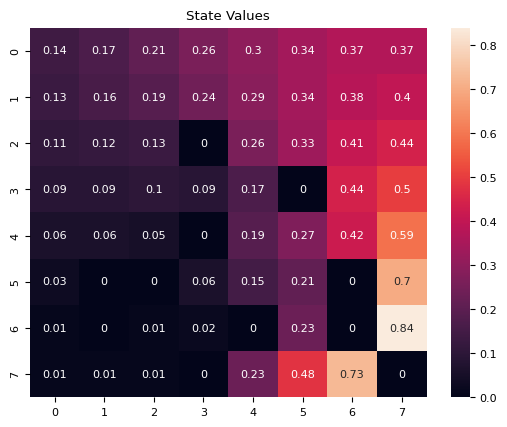

runtime = 0.04 seconds


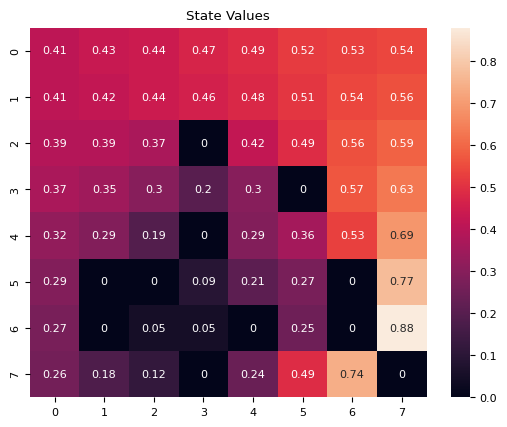

runtime = 0.07 seconds


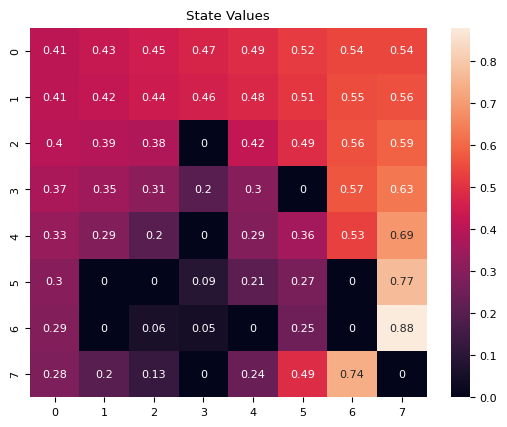

runtime = 0.07 seconds


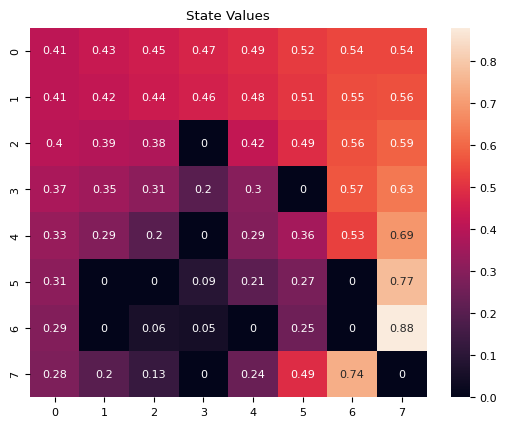

In [105]:

def policy_iteration(env, epsilon):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Initialize random policy
    policy = np.ones((num_states, num_actions)) / num_actions

    # Discount factor
    gamma = 0.99

    # Lists to store metrics
    num_iterations_list = []
    elapsed_times_list = []
    rewards_list = []

    # Policy Iteration algorithm
    for _ in range(100):  # Limit the number of iterations for demonstration
        # Policy Evaluation
        start_time_eval = time.time()
        V = np.zeros(num_states)
        while True:
            delta = 0
            for s in range(num_states):
                v = V[s]
                a = np.argmax(policy[s])  # Deterministic policy
                bellman_update = sum([p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]])
                V[s] = bellman_update
                delta = max(delta, np.abs(v - V[s]))

            if delta < epsilon:
                break
        end_time_eval = time.time()
        elapsed_time_eval = end_time_eval - start_time_eval

        # Policy Improvement
        start_time_improvement = time.time()
        policy_stable = True
        for s in range(num_states):
            old_action = np.argmax(policy[s])
            action_values = [sum([p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(num_actions)]
            best_action = np.argmax(action_values)
            policy[s] = np.eye(num_actions)[best_action]  # Convert to one-hot encoding
            if old_action != best_action:
                policy_stable = False

        end_time_improvement = time.time()
        elapsed_time_improvement = end_time_improvement - start_time_improvement

        # Store metrics
        num_iterations_list.append(_)
        elapsed_times_list.append(elapsed_time_eval + elapsed_time_improvement)

        # Test the policy
        total_reward = 0
        num_test_episodes = 10
        for _ in range(num_test_episodes):
            state = env.reset()
            done = False
            while not done:
                print(policy)
                action = np.argmax(policy[state])
                state, reward, done, _ = env.step(action)
                total_reward += reward

        avg_reward = total_reward / num_test_episodes
        rewards_list.append(avg_reward)

        if policy_stable:
            break

    return num_iterations_list, elapsed_times_list, rewards_list

def plot_epsilon_vs_metrics(epsilon_values, metrics, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))

    for i, metric_values in enumerate(metrics):
        plt.plot(epsilon_values, metric_values, label=f'Epsilon = {epsilon_values[i]}')

    plt.xscale('log')  # Use logarithmic scale for epsilon values
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


# Vary epsilon values
epsilon_values = [1e-2, 1e-3, 1e-4, 1e-5]
num_iterations_list = []
elapsed_times_list = []
rewards_list = []

pi_V_list = []
pi_V_track_list = []
pi_pi_list = []
pi_time_list = []
pi_scores_list = []

for epsilon in epsilon_values:
    start_time = time.time()
    V, V_track, pi = planner.policy_iteration(gamma=0.99, n_iters=1000, theta=epsilon)

    pi_V_list.append(V)
    pi_V_track_list.append(V_track)
    pi_pi_list.append(pi)
    pi_time_list.append(time.time() - start_time)
    Plots.grid_values_heat_map(V, "State Values")

    test_scores = TestEnv.test_env(env=frozen_lake.env, render=False, user_input=False, pi=pi)
    scores_list.append(test_scores)

# # Plot the results
# plot_epsilon_vs_metrics(epsilon_values, num_iterations_list, 'Epsilon', 'Number of Iterations', 'Effect of Epsilon on Policy Iteration Iterations')
# plot_epsilon_vs_metrics(epsilon_values, elapsed_times_list, 'Epsilon', 'Wall Clock Time (s)', 'Effect of Epsilon on Policy Iteration Wall Clock Time')
# plot_epsilon_vs_metrics(epsilon_values, rewards_list, 'Epsilon', 'Average Reward', 'Effect of Epsilon on Policy Iteration Average Reward')


  0%|          | 0/1000 [00:00<?, ?it/s]

runtime = 2.34 seconds
curr_iter = 1000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.9


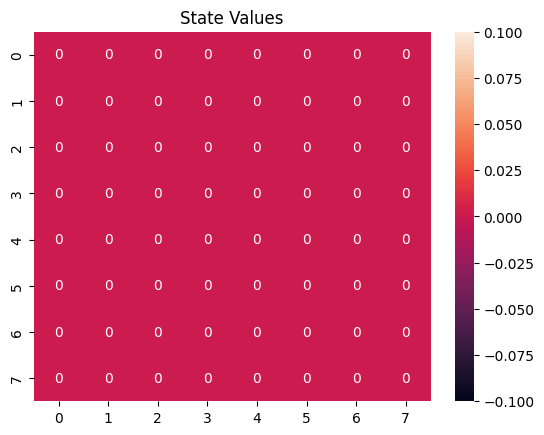

runtime = 2.28 seconds
curr_iter = 1000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.999


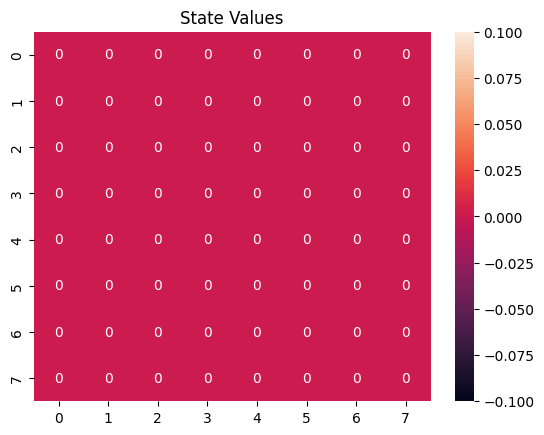

runtime = 2.44 seconds
curr_iter = 1000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.9


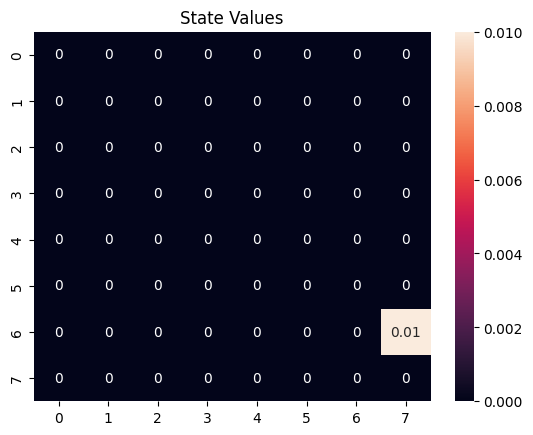

runtime = 2.31 seconds
curr_iter = 1000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.999


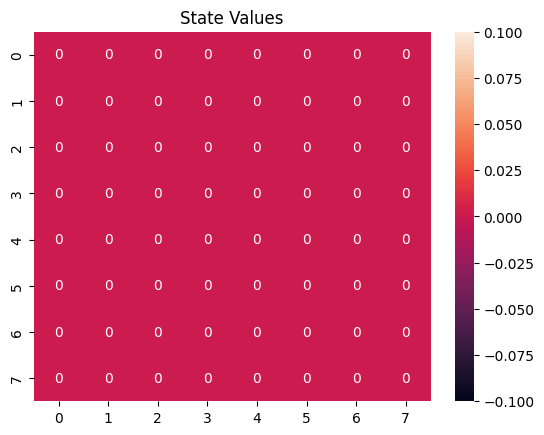

runtime = 2.14 seconds
curr_iter = 1000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.9


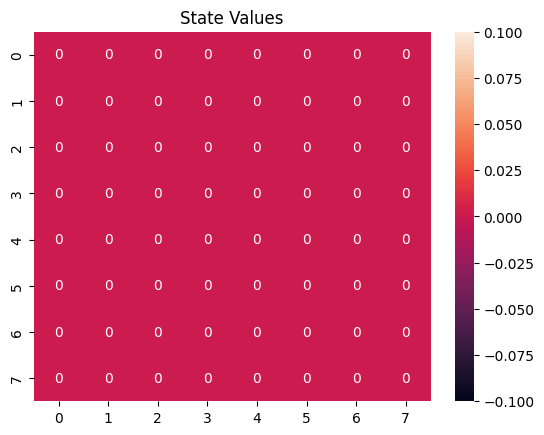

runtime = 2.31 seconds
curr_iter = 1000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.999


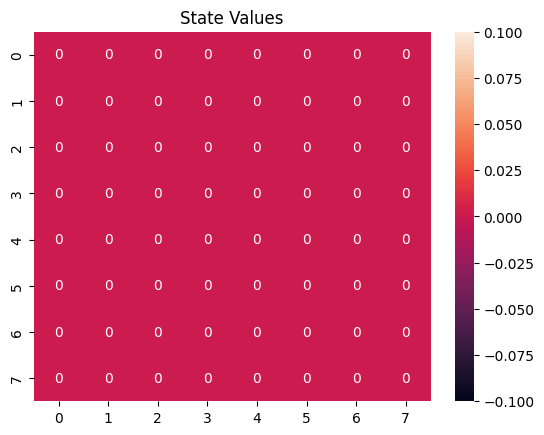

runtime = 2.38 seconds
curr_iter = 1000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.9


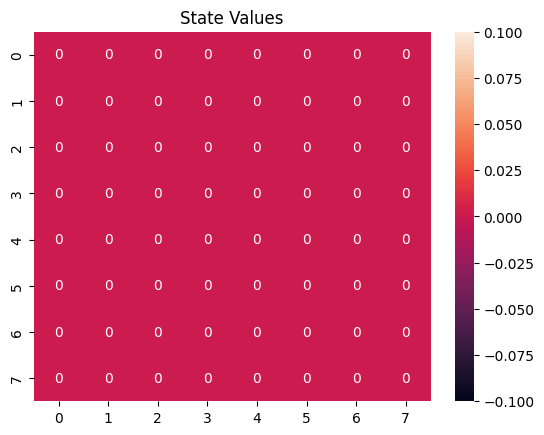

runtime = 2.09 seconds
curr_iter = 1000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.999


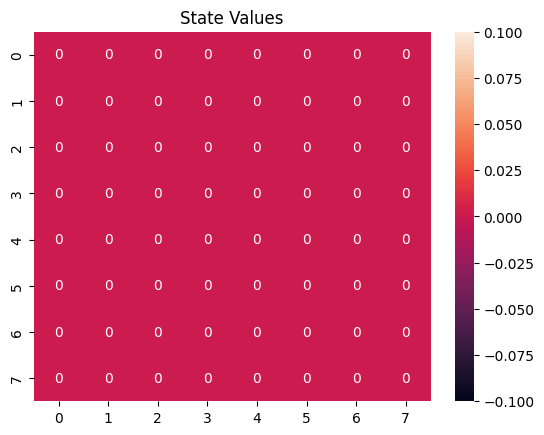

runtime = 22.89 seconds
curr_iter = 10000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.9


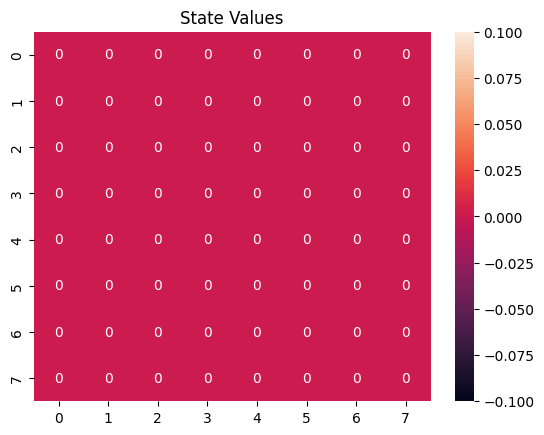

runtime = 23.73 seconds
curr_iter = 10000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.999


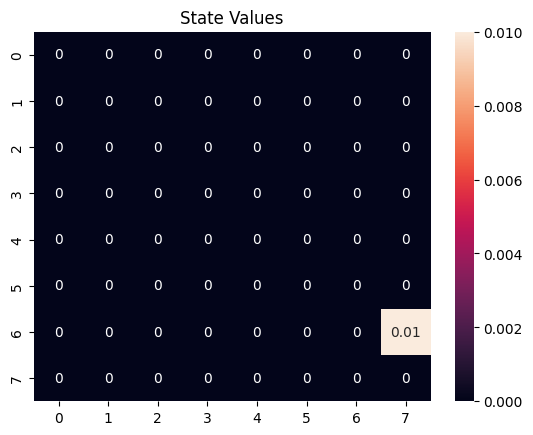

runtime = 22.41 seconds
curr_iter = 10000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.9


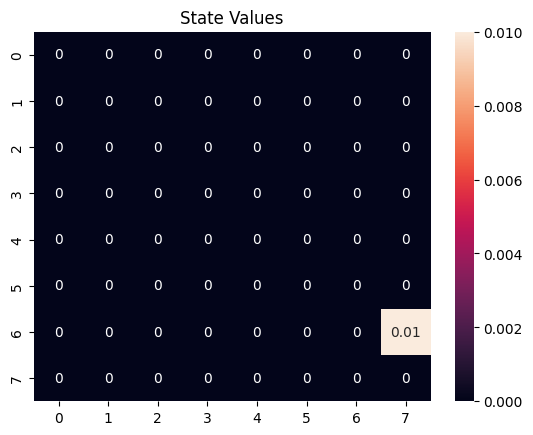

runtime = 21.93 seconds
curr_iter = 10000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.999


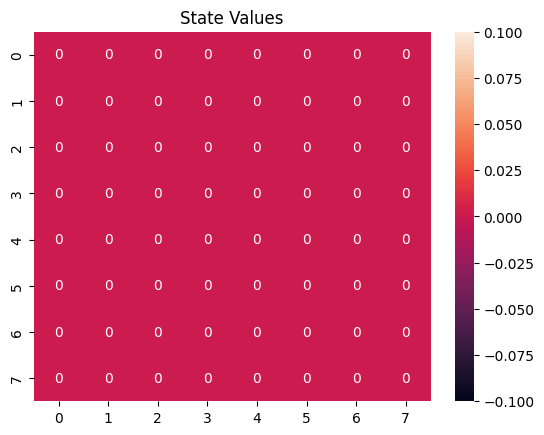

runtime = 23.20 seconds
curr_iter = 10000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.9


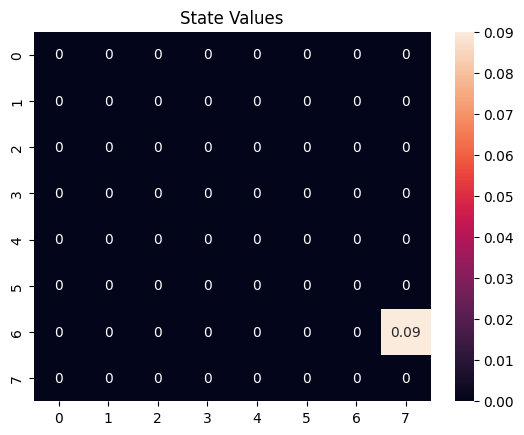

runtime = 15.97 seconds
curr_iter = 10000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.999


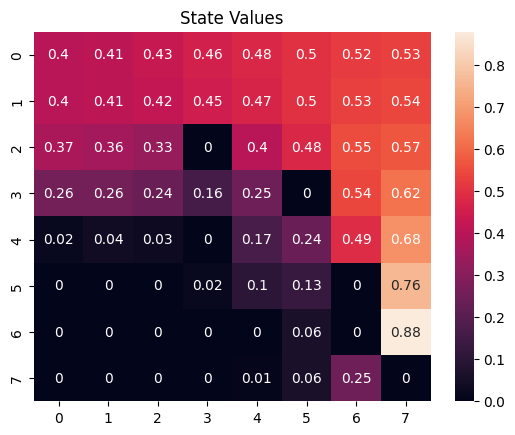

runtime = 23.95 seconds
curr_iter = 10000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.9


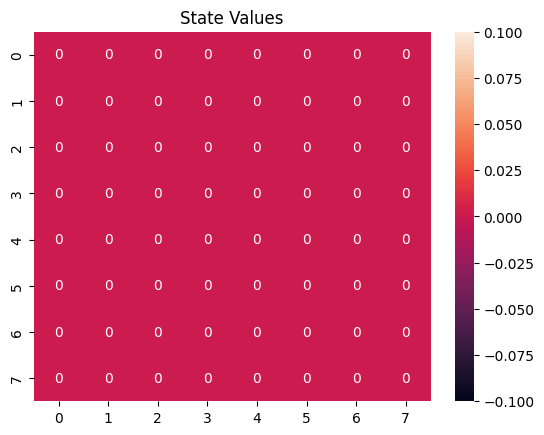

runtime = 21.24 seconds
curr_iter = 10000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.999


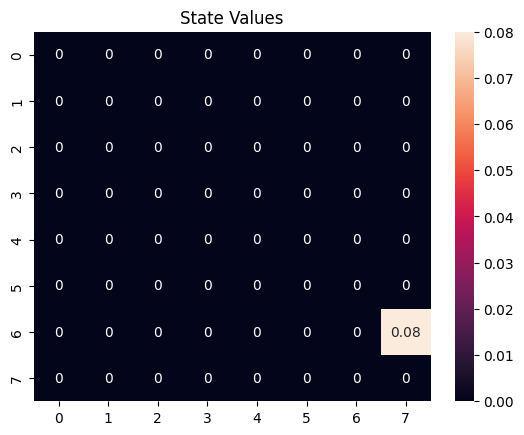

runtime = 77.48 seconds
curr_iter = 50000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.9


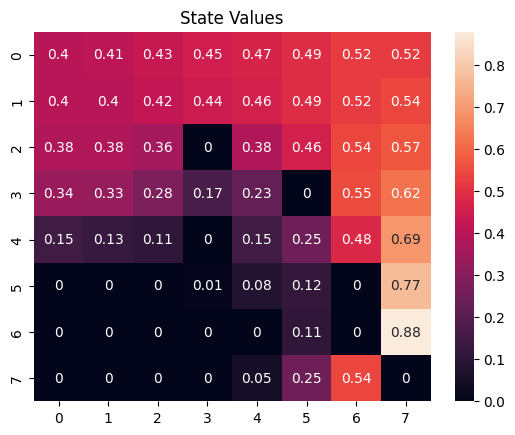

runtime = 83.53 seconds
curr_iter = 50000
alphas = 0.01
alpha_decays = 0.9
epsilon_decays = 0.999


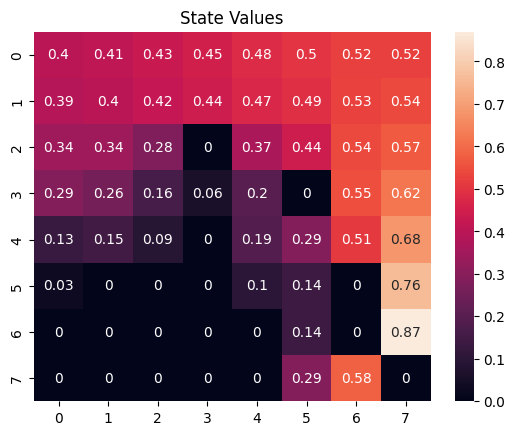

runtime = 69.15 seconds
curr_iter = 50000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.9


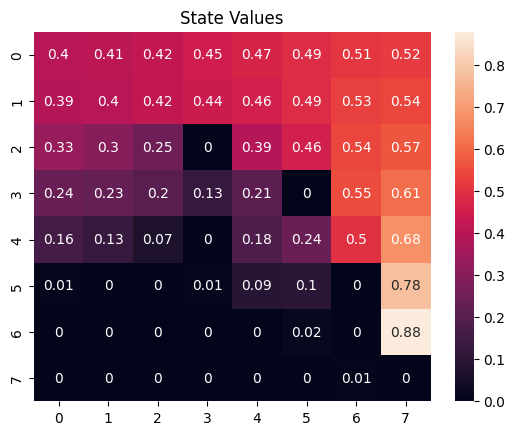

runtime = 110.12 seconds
curr_iter = 50000
alphas = 0.01
alpha_decays = 0.999
epsilon_decays = 0.999


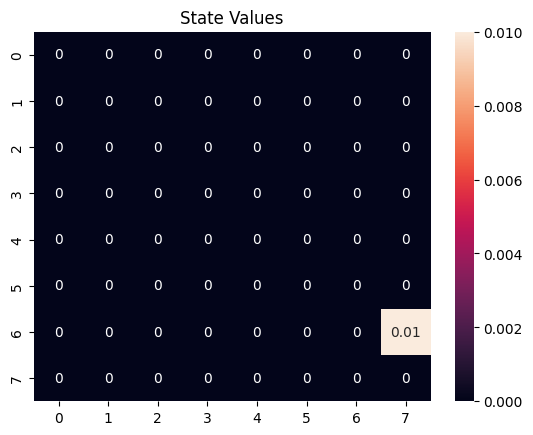

runtime = 111.54 seconds
curr_iter = 50000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.9


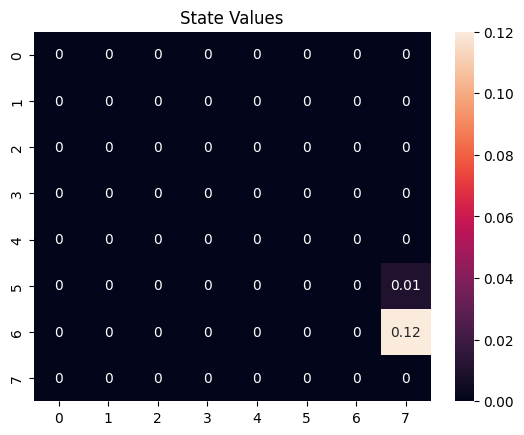

runtime = 77.22 seconds
curr_iter = 50000
alphas = 0.1
alpha_decays = 0.9
epsilon_decays = 0.999


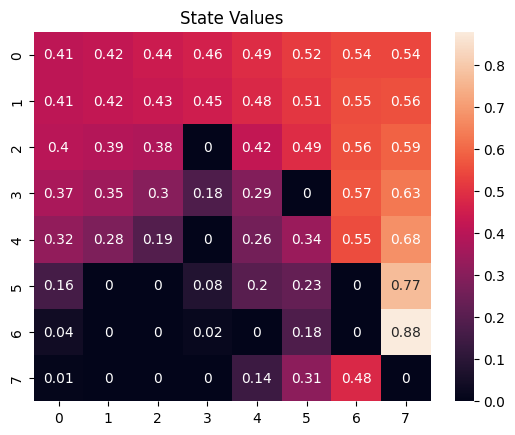

runtime = 78.12 seconds
curr_iter = 50000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.9


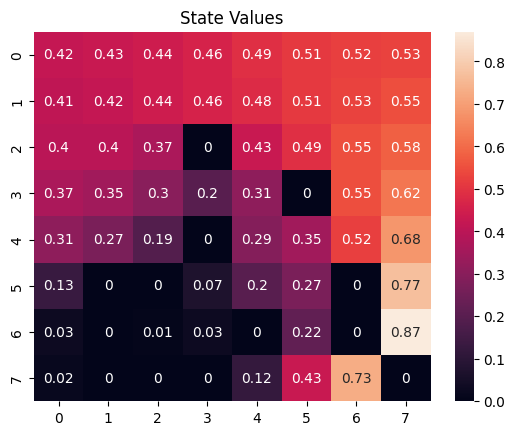

runtime = 77.35 seconds
curr_iter = 50000
alphas = 0.1
alpha_decays = 0.999
epsilon_decays = 0.999


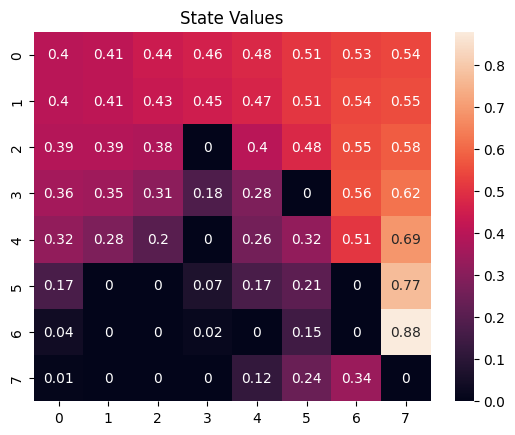

In [9]:
gammas = [0.99]
alphas = [0.01, 0.1]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1000, 10000, 50000]

for curr_iter in iterations:
    for a in alphas:
        for ad in alpha_decays:
            for ed in epsilon_decays:
                Q, V, pi, Q_track, pi_track = RL(frozen_lake.env).q_learning(
                    gamma=0.99,
                    init_alpha=a,
                    min_alpha=0.01,
                    alpha_decay_ratio=ad,
                    init_epsilon=1.0,
                    min_epsilon=0.1,
                    epsilon_decay_ratio=ed,
                    n_episodes=curr_iter,
                )
                print("curr_iter = " + str(curr_iter))            
                print("alphas = " + str(a))            
                print("alpha_decays = " + str(ad))
                print("epsilon_decays = " + str(ed))

                Plots.grid_values_heat_map(V, "State Values")

runtime = 82.05 seconds
curr_iter = 50000


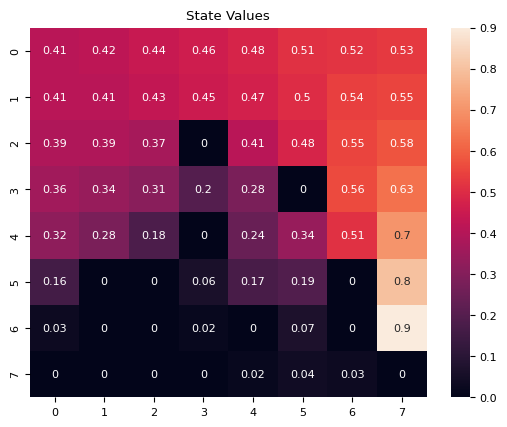

runtime = 158.24 seconds
curr_iter = 100000


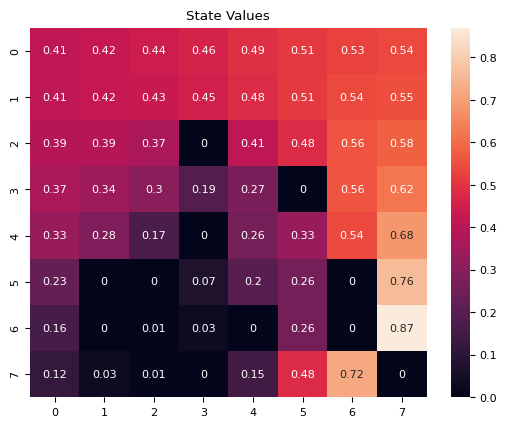

runtime = 235.20 seconds
curr_iter = 150000


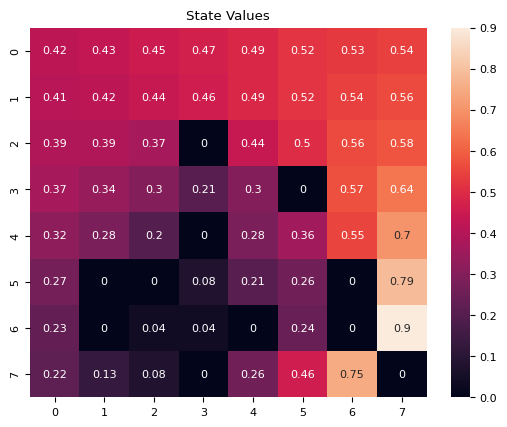

: 

In [110]:
iterations = [50000, 100000, 150000]

for curr_iter in iterations:
    Q, V, pi, Q_track, pi_track = RL(frozen_lake.env).q_learning(
        gamma=0.99,
        init_alpha=a,
        min_alpha=0.01,
        alpha_decay_ratio=0.9,
        init_epsilon=1.0,
        min_epsilon=0.1,
        epsilon_decay_ratio=0.9,
        n_episodes=curr_iter,
    )

    print("curr_iter = " + str(curr_iter))

    Plots.grid_values_heat_map(V, "State Values")